In [2]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi

In [2]:
save_path = "data"
url = (
    "https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true"
)
adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url=url)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

In [3]:
vae = scvi.module.VAE(6855,n_latent=10)

In [6]:
epochs = 10
for i in range(epochs):
    for cell in adata:
        pass

Exception ignored in: <function _xla_gc_callback at 0x7ff55ee319d0>
Traceback (most recent call last):
  File "/Applications/Anaconda/anaconda3/envs/ML/lib/python3.9/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [5]:
scvi.model.LinearSCVI.setup_anndata(adata, layer = "counts")

In [6]:
model = scvi.model.LinearSCVI(adata, n_latent = 10)

In [7]:
model.train(max_epochs = 100, plan_kwargs = {"lr":5e-3},check_val_every_n_epoch=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it, loss=381, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it, loss=381, v_num=1]


In [8]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

<AxesSubplot:xlabel='epoch'>

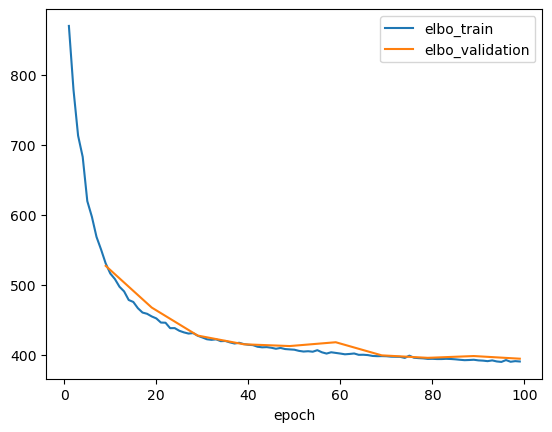

In [9]:
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [10]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

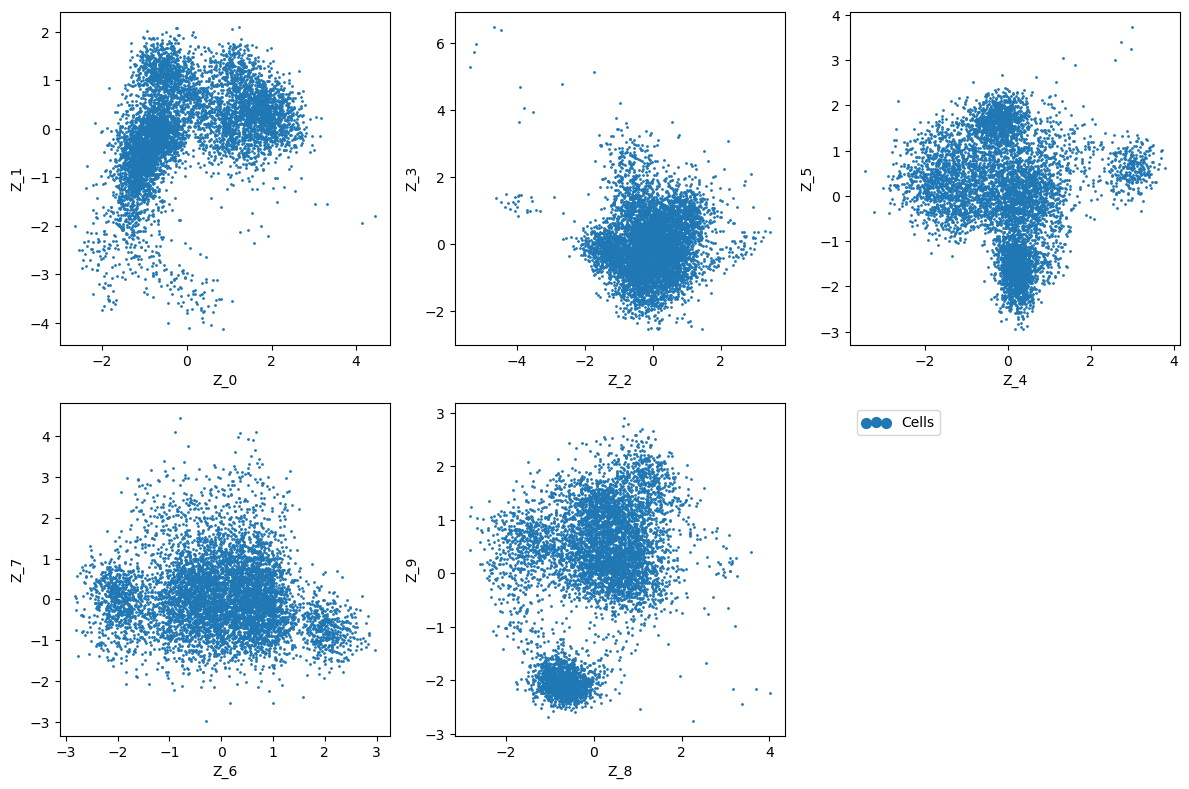

In [11]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(
        adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(
    adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

In [12]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.624825,-0.048130,0.257448,-0.161901,0.106890,-0.007128,-0.127744,-0.301338,-0.147139,0.285727
HES4,0.531296,-0.584311,0.408714,-0.443889,0.225420,-0.201762,-0.337094,-0.290278,-0.205159,0.320716
ISG15,0.399156,-0.039984,0.181028,-0.244600,-0.200384,0.370926,-0.014700,-0.147028,0.135238,0.152465
TNFRSF18,0.280120,-0.609206,0.338467,-0.090426,-1.256298,1.052421,0.507948,-0.505561,0.468060,0.621860
TNFRSF4,0.698143,-0.462781,0.267140,-0.355157,-1.306632,1.027268,0.709345,-0.274072,0.390094,0.290891


In [13]:
print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	CCL3L1, -0.99	CCL3, -0.91	HLA-DQA1, -0.88	HLA-DQB1, -0.77	HLA-DRA, -0.71
	...
	LEF1, 1.4	CCR7, 1.4	LRRN3, 1.5	CD40LG, 1.6	TSHZ2, 1.8
---------------------------------------------------------------------------------------

Z_1:	C1QA, -1.3	C1QB, -1.1	MGLL, -1.1	PLD4, -0.91	BATF3, -0.84
	...
	TRGC2, 1.1	TRAV4, 1.4	LINC02446, 1.7	CD8A, 2.6	CD8B, 2.8
---------------------------------------------------------------------------------------

Z_2:	GZMB, -1.1	LINC02446, -0.91	PTGDS, -0.86	SERPINF1, -0.76	TKTL1, -0.71
	...
	CTLA4, 0.71	CKB, 0.74	COL5A3, 0.8	CDKN1C, 0.92	GZMK, 1.3
---------------------------------------------------------------------------------------

Z_3:	TRDC, -1.6	KLRC2, -1.3	LINC02446, -1.2	S100B, -1.2	XCL1, -1.2
	...
	PPP1R14A, 0.65	COCH, 0.68	LTK, 0.81	BASP1, 0.81	BLK, 0.96
--------------------------------------------------------------------------------------

In [15]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

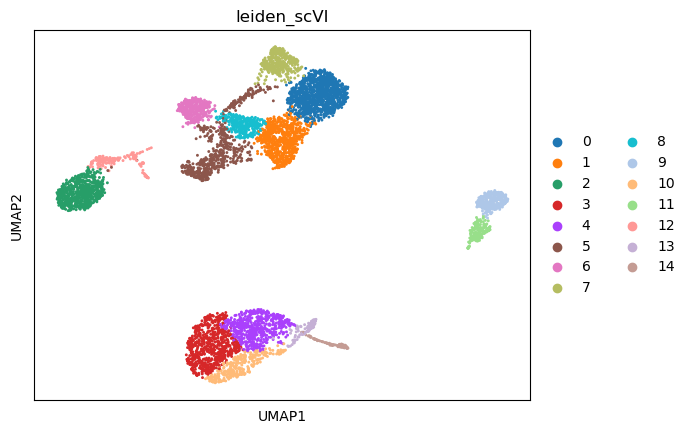

In [16]:
sc.pl.umap(adata, color=["leiden_scVI"])

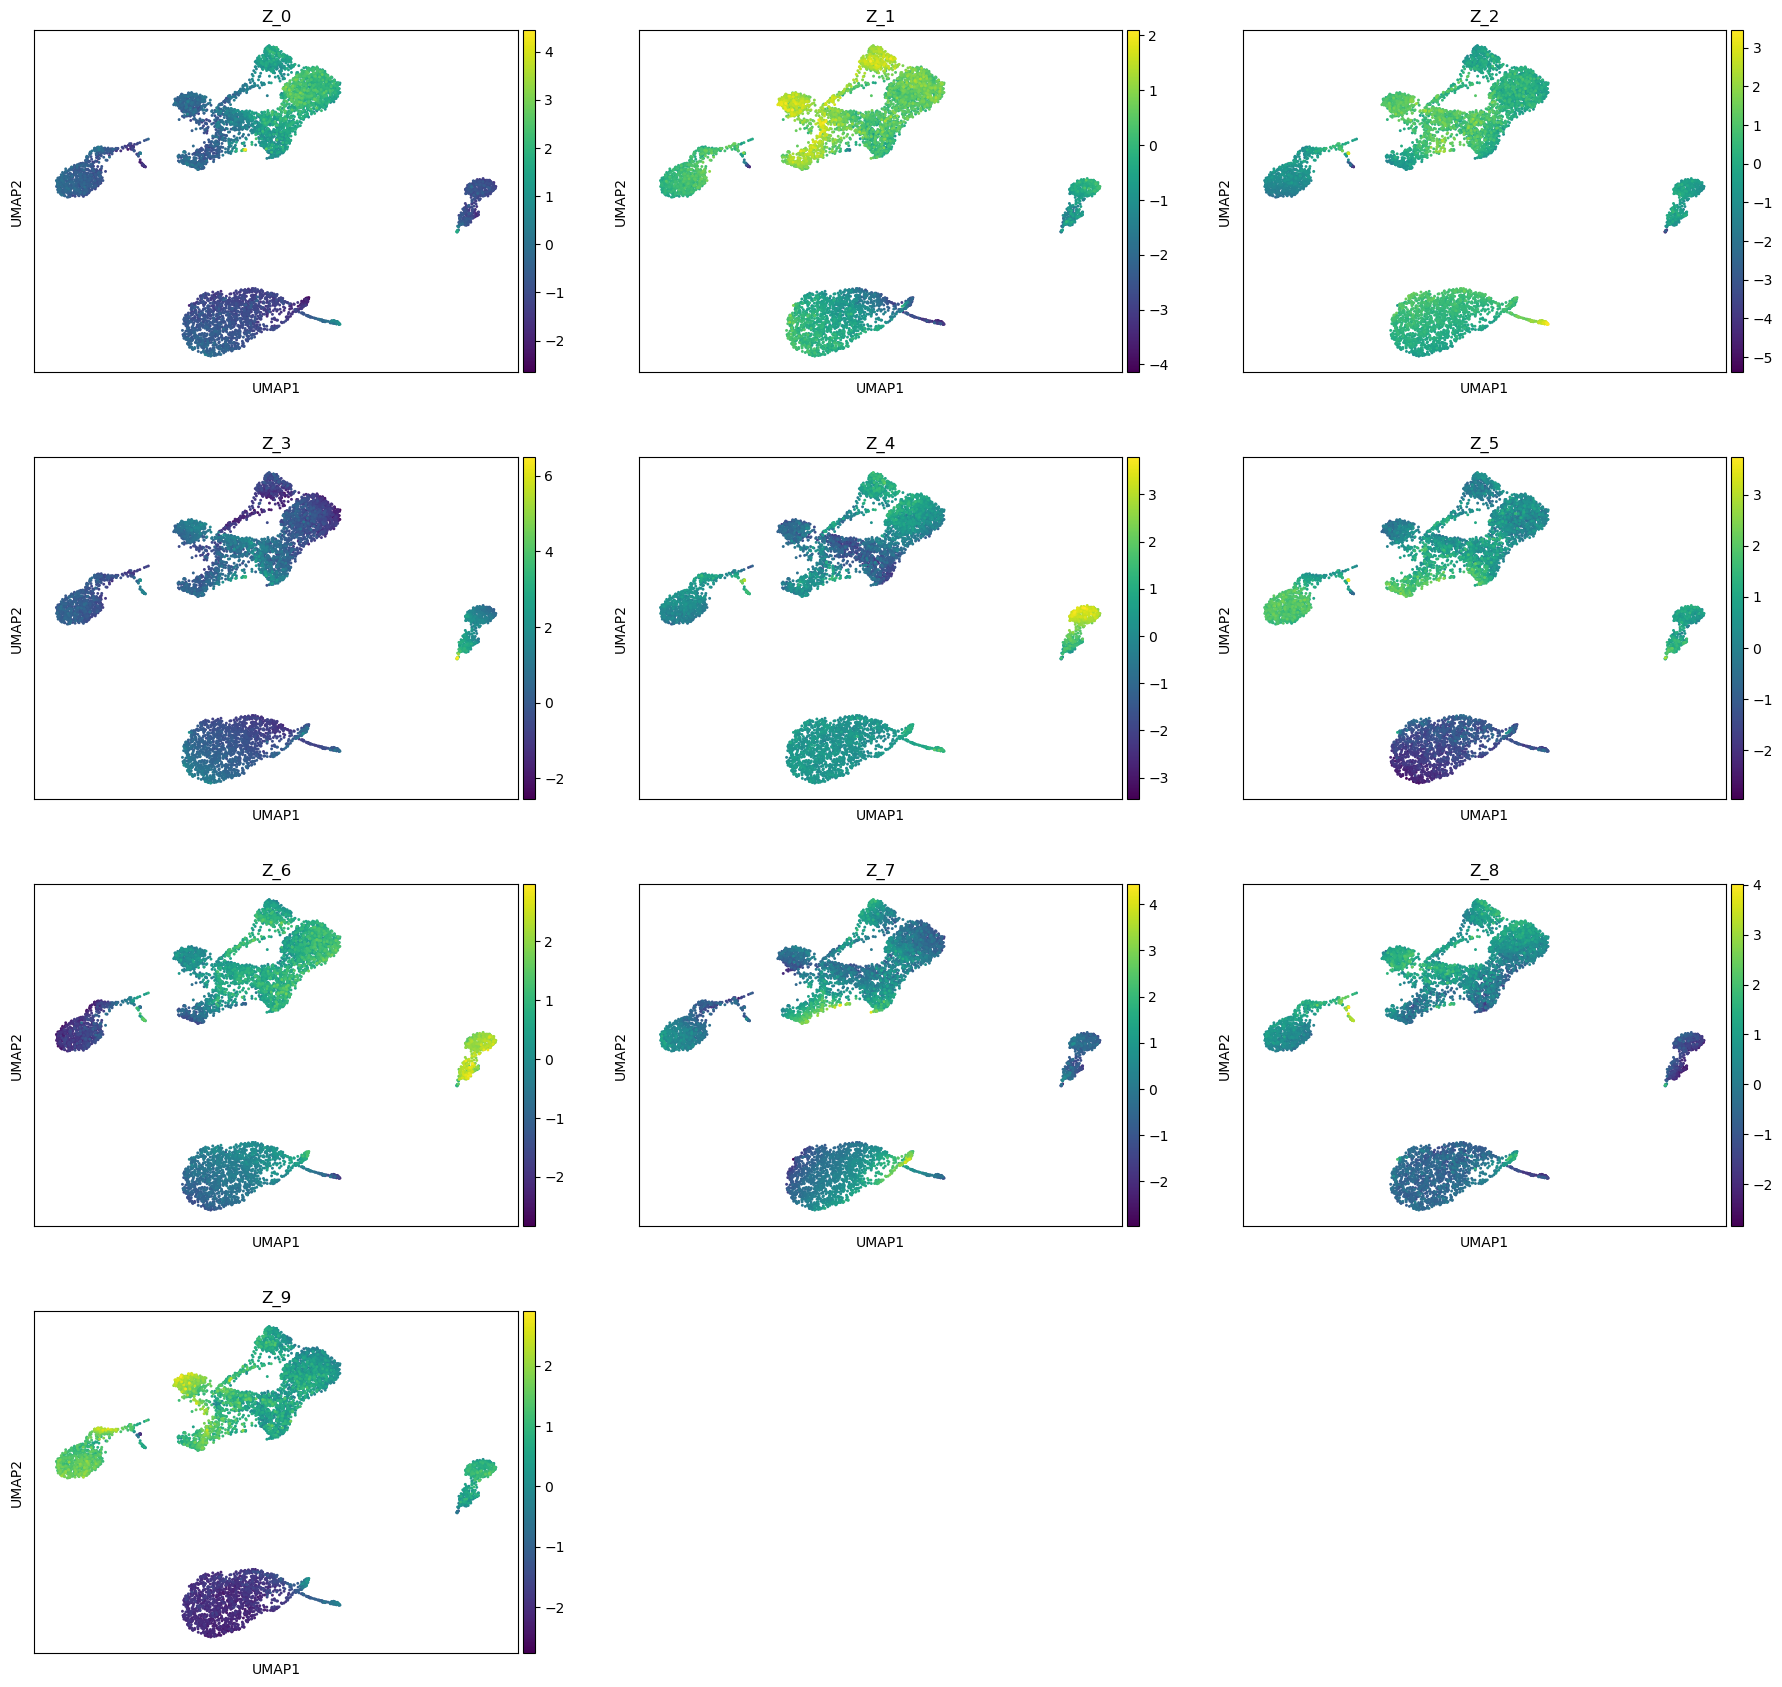

In [17]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)